## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [1]:
import os
import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.FPVAE_T20 import *
from Utilities.Utilities import *
from Utilities.EvaluationModules import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

#### Env setting

In [2]:
LatDim = 10
MaskingRate = 0.02
NoiseStd = 0.002
MaskStd = 0.1
ReparaStd = 0.1
Capacity_Z = 0.1
Capacity_Fc = 0.1
FcLimit = 0.05
DecayH = 0. 
DecayL = 0.
SlidingSize = 50
SigType ='ART'

### Other parameters
Patience = 300
TrRate = 0.8

SavePath = './Results/'
ModelName = 'TCMIL_'+str(SigType)+'_Z'+str(LatDim)+'.hdf5'

if not os.path.exists(SavePath):
    os.mkdir(SavePath)

### Model checkpoint
ModelSaveName = SavePath+ModelName

### Data

In [3]:
ValData = np.load('./Data/ProcessedData/ValART.npy')
SigDim = ValData.shape[1]

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'ReconModel')>

### Post model

In [4]:
# Defining BioSigBandVAE
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(SigDim=SigDim, LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=400)

## Model core parts
EncInp =EncModel.input
InpZ = EncModel.output[2]
InpFCCommon = EncModel.output[1][:, :2]
InpFCEach = EncModel.output[1][:, 2:]

## Each output of each model
FeatExtOut = FeatExtModel(EncModel.output[:2])
FeatGenOut = FeatGenModel([InpFCCommon, InpFCEach, InpZ])
ReconExtOut = ReconModel(FeatExtOut)
ReconGenOut = ReconModel(FeatGenOut)

### Define the total model
SigBandRepModel = Model(EncInp, [FeatGenOut, ReconExtOut, ReconGenOut])

### Weight controller; Apply beta and capacity 
Beta_Z = Lossweight(name='Beta_Z', InitVal=0.05)(FeatGenOut)
Beta_Fc = Lossweight(name='Beta_Fc', InitVal=0.05)(FeatGenOut)
Beta_TC = Lossweight(name='Beta_TC', InitVal=0.05)(FeatGenOut)
Beta_MI = Lossweight(name='Beta_MI', InitVal=0.05)(FeatGenOut)
Beta_Rec_ext = Lossweight(name='Beta_Rec_ext', InitVal=500.)(FeatGenOut)
Beta_Rec_gen = Lossweight(name='Beta_Rec_gen', InitVal=500.)(FeatGenOut)
Beta_Feat = Lossweight(name='Beta_Feat', InitVal=500.)(FeatGenOut)

### Adding the RecLoss; 
MSE = tf.keras.losses.MeanSquaredError()

ReconOut_ext = Beta_Rec_ext * MSE(ReconExtOut, EncInp)
SigBandRepModel.add_loss(ReconOut_ext)
SigBandRepModel.add_metric(ReconOut_ext, 'ReconOut_ext')

#ReconOut_gen = Beta_Rec_gen * MSE(ReconGenOut, EncInp)
#SigBandRepModel.add_loss(ReconOut_gen)
#SigBandRepModel.add_metric(ReconOut_gen, 'ReconOut_gen')


### Adding the FeatRecLoss; It allows connection between the extractor and generator
FeatRecLoss= Beta_Feat * MSE(tf.concat(FeatGenOut, axis=-1), tf.concat(FeatExtOut, axis=-1))
SigBandRepModel.add_loss(FeatRecLoss)
SigBandRepModel.add_metric(FeatRecLoss, 'FeatRecLoss')

### KL Divergence for p(Z) vs q(Z)
Z_Mu, Z_Log_Sigma, Zs = SigBandRepModel.get_layer('Z_Mu').output, SigBandRepModel.get_layer('Z_Log_Sigma').output, SigBandRepModel.get_layer('Zs').output
kl_Loss_Z = 0.5 * tf.reduce_sum( Z_Mu**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss_Z = tf.reduce_mean(kl_Loss_Z )
kl_Loss_Z = Beta_Z * tf.abs(kl_Loss_Z - Capacity_Z)

### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
FCs = SigBandRepModel.get_layer('FC_Mu').output 
kl_Loss_FC = tf.math.log(FCs) - tf.math.log(BernP) + tf.math.log(1-FCs) - tf.math.log(1-BernP) 
kl_Loss_FC = tf.reduce_mean(-kl_Loss_FC )
kl_Loss_FC = Beta_Fc * tf.abs(kl_Loss_FC - Capacity_Fc)


### KL Divergence for q(Z) vs q(Z)_Prod
LogProb_QZ = LogNormalDensity(Zs[:, None], Z_Mu[None], Z_Log_Sigma[None])
Log_QZ_Prod = tf.reduce_sum( tf.reduce_logsumexp(LogProb_QZ, axis=1, keepdims=False),   axis=1,  keepdims=False)
Log_QZ = tf.reduce_logsumexp(tf.reduce_sum(LogProb_QZ, axis=2, keepdims=False),   axis=1,   keepdims=False)
kl_Loss_TC = -tf.reduce_mean(Log_QZ - Log_QZ_Prod)
kl_Loss_TC = Beta_TC * kl_Loss_TC

### MI Loss ; I[z;x] = KL[q(z,x)||q(x)q(z)] = E_x[KL[q(z|x)||q(z)]]
Log_QZX = tf.reduce_sum(LogNormalDensity(Zs, Z_Mu, Z_Log_Sigma), axis=1)
kl_Loss_MI = -tf.reduce_mean((Log_QZX - Log_QZ))
kl_Loss_MI = Beta_MI * kl_Loss_MI



SigBandRepModel.add_loss(kl_Loss_Z )
SigBandRepModel.add_metric(kl_Loss_Z , 'kl_Loss_Z')

SigBandRepModel.add_loss(kl_Loss_FC )
SigBandRepModel.add_metric(kl_Loss_FC , 'kl_Loss_FC')

SigBandRepModel.add_loss(kl_Loss_TC )
SigBandRepModel.add_metric(kl_Loss_TC , 'kl_Loss_TC')

SigBandRepModel.add_loss(kl_Loss_MI )
SigBandRepModel.add_metric(kl_Loss_MI , 'kl_Loss_MI')

### Load weights
SigBandRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigBandRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_Rec_ext','Beta_Rec_gen', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigBandRepModel.compile(optimizer='adam') 

In [12]:
SigBandRepModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_14 (TFOpLambda) (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 20, 50)       2550        tf.signal.frame_14[0][0]         
__________________________________________________________________________________________________
bidirectional_36 (Bidirectional (None, 20, 50)       11550       dense_64[0][0]                   
____________________________________________________________________________________________

In [19]:
if 5:
    print('true')

true


### Reconstruction; MSE

In [38]:
RecPred = SigBandRepModel.predict(ValData,  batch_size=3500, verbose=1)[-1]

23/23 [==============================] - 14s 203ms/step


In [41]:
SigBandRepModel.evaluate(ValData,  batch_size=3500, verbose=1)

23/23 [==============================] - 4s 162ms/step - loss: 18.7876 - ReconOutGen: 0.0036 - FeatRecLoss: 5.6729e-04 - kl_Loss_Z: 0.4808 - kl_Loss_FC: 0.0589 - kl_Loss_TC: 18.2436


[18.78759765625,
 0.003648278769105673,
 0.000567288079764694,
 0.48082607984542847,
 0.05892202630639076,
 18.243633270263672]

In [ ]:
EvalMSE = tf.keras.losses.MeanSquaredError()
EvalMSE(ValData, RecPred)

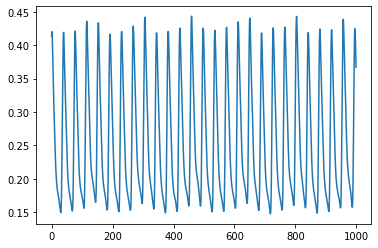

In [48]:
plt.plot(ValData[0])

### From extractor to reconstruction validation 
#### It ultimately evaluates the performance of the reconstructor

(200, 1000)


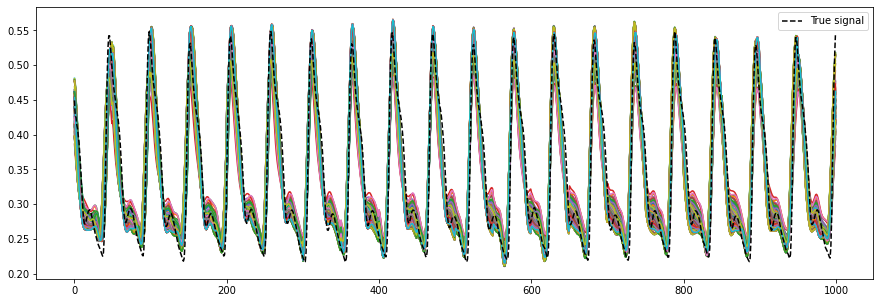

In [5]:
idx = 51
N_Gen = 200
'''
FC_Comm = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,4))

'''
FC_Comm = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,2))
FC_Comm = np.sort(FC_Comm)
FC_Each = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,4))
FC_Each = np.sort(FC_Each)


RecPred, HH,HL,LH, LL = VisReconExtract (ValData, idx, FeatExtModel, ReconModel, FC_Comm, FC_Each, N_Gen=N_Gen)

#### From extractor to reconstruction LL

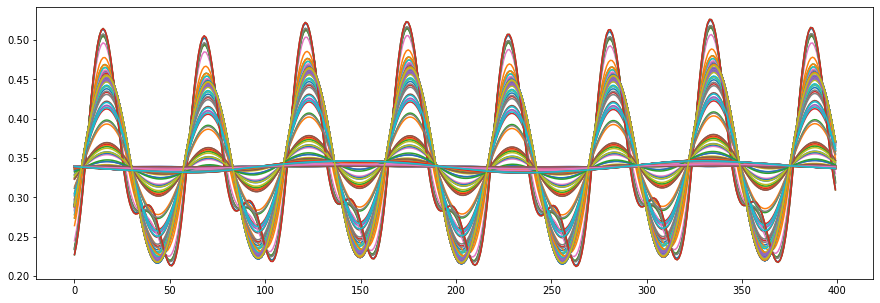

In [6]:
plt.figure(figsize=(15, 5))
for i in range(N_Gen):
    plt.plot(LL.numpy()[i])

#### From extractor to reconstruction HH

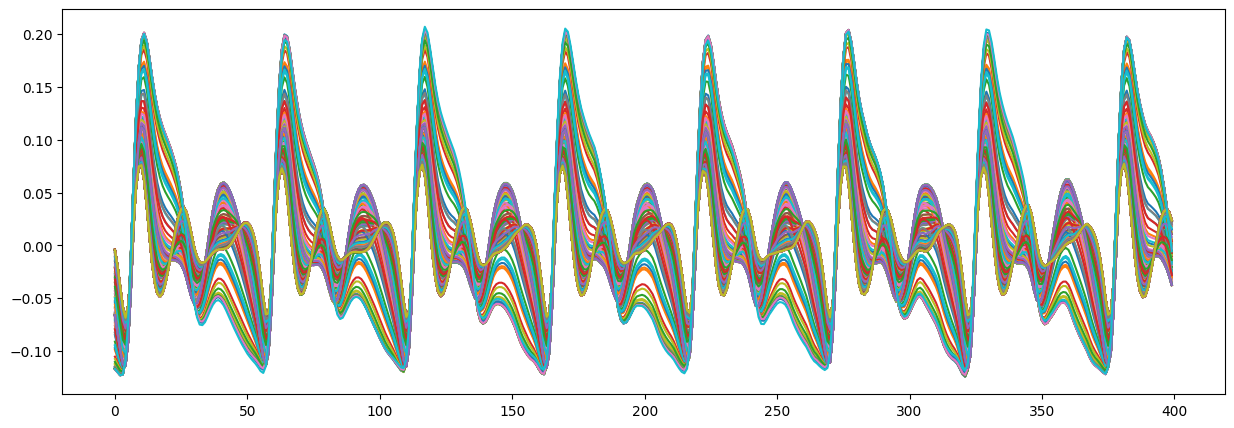

In [7]:
plt.figure(figsize=(15, 5))
for i in range(N_Gen):
    plt.plot(HH.numpy()[i])

(0.5, 0.17999999999999994)

### Permutation Local Correlation Monotonicity Index (PLCMI)

In [6]:
PLCMI_Res = PLMI(FeatGenModel,  ReconModel, LatDim=10, N_Gen=300, N_Interval=20, MonoWinSize=300, MinZval = -5., MaxZval = 5., N_FreqSel =1,  MinFreq=1, MaxFreq=51, Weight='Amplitude', Type='Cor')

[0, -5.0, 1.3833]
[0, -4.47, 1.8616]
[0, -3.95, 2.4575]
[0, -3.42, 1.0785]
[0, -2.89, 3.3146]
[0, -2.37, 3.228]
[0, -1.84, 2.959]
[0, -1.32, 2.8263]
[0, -0.79, 2.3061]
[0, -0.26, 1.1041]
[0, 0.26, 1.8779]
[0, 0.79, 1.2393]
[0, 1.32, 3.0246]
[0, 1.84, 2.9526]
[0, 2.37, 1.3242]
[0, 2.89, 2.1125]
[0, 3.42, 2.8764]
[0, 3.95, 2.7048]
[0, 4.47, 3.1548]
[0, 5.0, 2.9899]
[1, -5.0, 2.1588]
[1, -4.47, 2.9899]
[1, -3.95, 2.9564]
[1, -3.42, 2.94]
[1, -2.89, 2.524]
[1, -2.37, 3.4425]
[1, -1.84, 3.3281]
[1, -1.32, 2.2534]
[1, -0.79, 3.3054]
[1, -0.26, 2.7522]
[1, 0.26, 3.1807]
[1, 0.79, 2.9271]
[1, 1.32, 0.6996]
[1, 1.84, 1.0104]
[1, 2.37, 1.7578]
[1, 2.89, 3.1051]
[1, 3.42, 3.1377]
[1, 3.95, 3.1316]
[1, 4.47, 3.0705]
[1, 5.0, 3.223]
[2, -5.0, 3.3158]
[2, -4.47, 3.2318]
[2, -3.95, 3.3476]
[2, -3.42, 3.0992]
[2, -2.89, 2.9619]
[2, -2.37, 3.0829]
[2, -1.84, 2.7264]
[2, -1.32, 1.8913]
[2, -0.79, 3.3215]
[2, -0.26, 3.2872]
[2, 0.26, 3.1526]
[2, 0.79, 2.6444]
[2, 1.32, 2.1394]
[2, 1.84, 1.8923]
[2, 2.37,

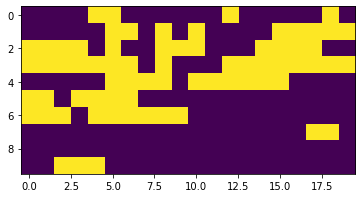

In [7]:
plt.imshow(np.array(PLCMI_Res)[:, -1].reshape(-1, 20) > 3.0)

### Qualitative evaluation of the amplitude relationship between the input frequency for signal generation (y-axis) and the frequency of the generated signal (x-axis).

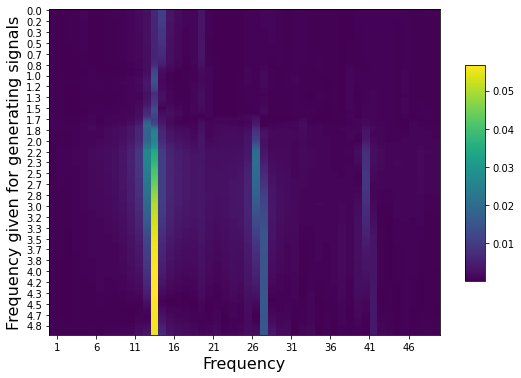

In [35]:
ZFix = {9:-1.84}
#ZFix = {2:1.32, 9:3.32}
#zVal[:,0] = -3
#Val[:,1] = 2.33
#zVal[:,2] = 0.4
#zVal[:,3] = -1.67
#zVal[:,4] = 0.33
#zVal[:,5] = 3
#zVal[:,6] = -1.67
#zVal[:,7] = 3
#zVal[:,8] = 3
#zVal[:,9] = -1

HeatMapFrequency(FeatGenModel,  ReconModel, LatDim, ZFix, N_Gen=300)

### Visualizing the reconstruction conditioned on a specific z-value when frequencies are given at regular intervals
#### Objective: This qualitatively evaluates the impact of changes in input frequencies on signal generation when a specific z-value is given.

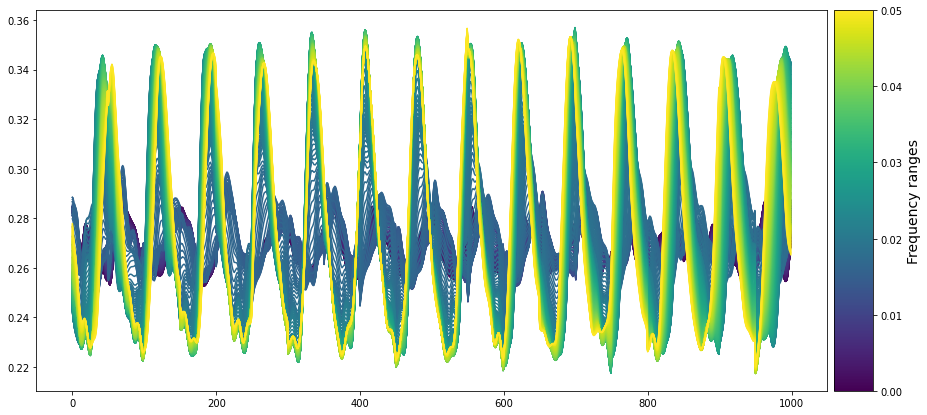

In [36]:
RecPred, HH,HL,LH, LL = VisReconGivenZ (FeatGenModel,  ReconModel, LatDim, ZFix, Mode='Origin', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

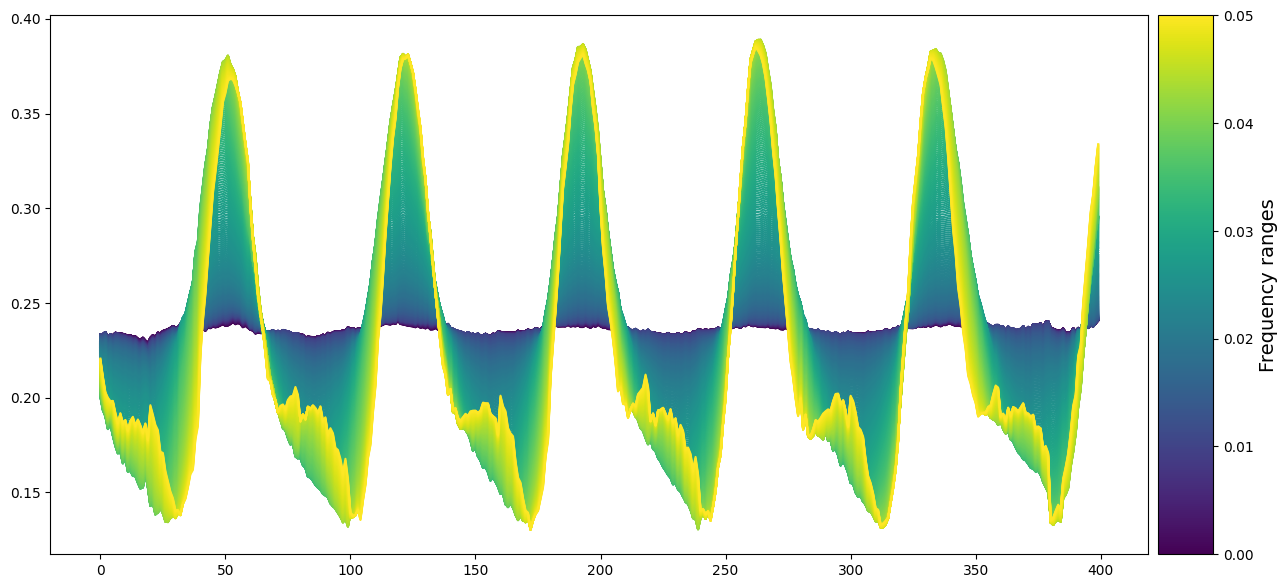

In [40]:
#ZFix = {6:-3.}
RecPred, HH,HL,LH, LL = VisReconGivenZ (FeatGenModel,  ReconModel, LatDim, ZFix, Mode='LL', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

### Visualizing the reconstruction conditioned on a specific frequency value when z-values are given at regular intervals
#### Objective: This qualitatively evaluates the impact of changes in input z-values on signal generation when a specific frequency is given.

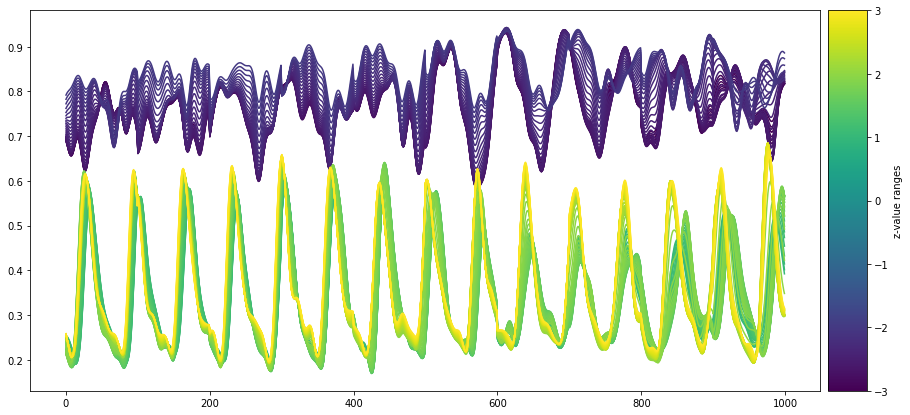

In [21]:
FcCommFix = {0:0.05, 1:0.05}
FcEachFix = {0:0.05, 1:0.05, 2:0.05, 3:0.05}
RecPred, HH,HL,LH, LL = VisReconGivenFreq (FeatGenModel,  ReconModel, LatDim, FcCommFix, FcEachFix,  Mode='Origin', N_Gen=200, MinZval = -3., MaxZval = 3., CutLower=-2., CutUpper = 1.)

### From generator to reconstruction validation

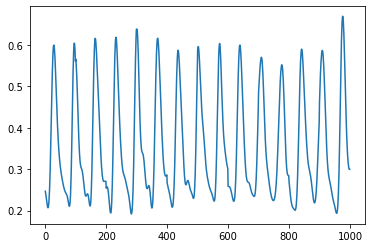

In [25]:
idx = 175
plt.plot(RecPred[idx])

### Visualizing amplitude by frequency given a specific ID

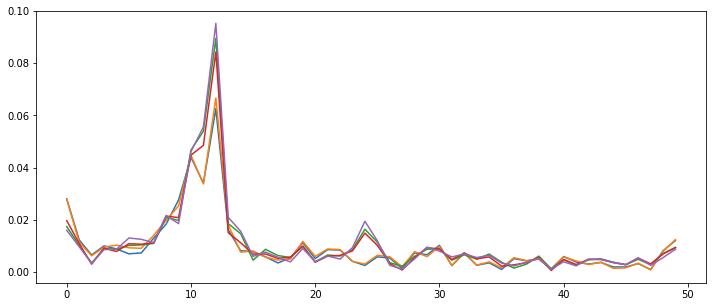

In [26]:
# GenSig_zVar
N_Gen= 300
SigGen5, Amplitude5 = GenSig_zVar(FeatGenModel, ReconModel, 0.05, N_Gen=N_Gen)
SigGen4, Amplitude4 = GenSig_zVar(FeatGenModel, ReconModel,  0.04, N_Gen=N_Gen)
SigGen3, Amplitude3 = GenSig_zVar(FeatGenModel, ReconModel,  0.03, N_Gen=N_Gen)
SigGen2, Amplitude2 = GenSig_zVar(FeatGenModel, ReconModel,  0.02, N_Gen=N_Gen)
SigGen1, Amplitude1 = GenSig_zVar(FeatGenModel, ReconModel,  0.01, N_Gen=N_Gen)

plt.figure(figsize=(12, 5))
idx = 20
plt.plot(Amplitude5[idx, 1:51])
plt.plot(Amplitude4[idx, 1:51])
plt.plot(Amplitude3[idx, 1:51])
plt.plot(Amplitude2[idx, 1:51])
plt.plot(Amplitude1[idx, 1:51])

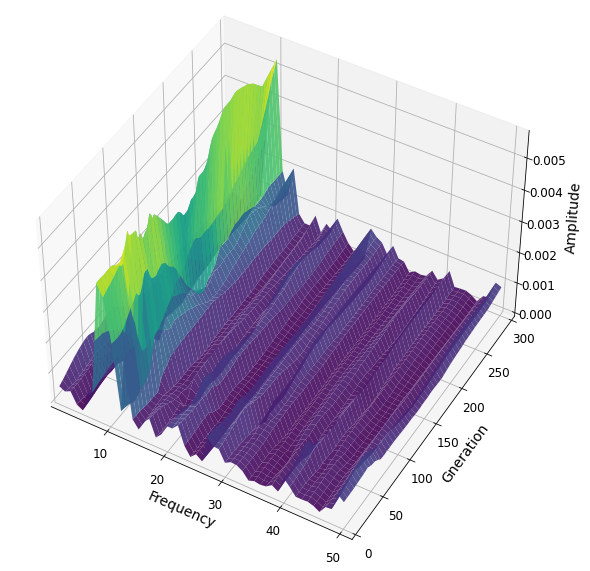

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N_Gen = 300
MinFreq=1
MaxFreq=50


# GenSig_FcVar
zVal = np.tile(np.zeros(LatDim), (N_Gen,1))
SigGen_FcVar, Amplitude_FcVar = GenSig_FcVar(FeatGenModel,  ReconModel,zVal, N_Gen=N_Gen, zType='Fixed')

# Axes generation
FreqX = np.arange(0, N_Gen)
GenY = np.arange(MinFreq, MaxFreq+1)
FreqX, GenY = np.meshgrid(GenY, FreqX)

# 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(FreqX, GenY, Amplitude_FcVar[:, MinFreq:MaxFreq+1], cmap='viridis', linewidth=1, antialiased=True, alpha = 0.9)

# Axis labels
ax.set_xlabel('Frequency', fontsize=14, labelpad=5.5)
ax.set_xticks(ax.get_xticks())
ax.tick_params(axis='x', labelsize=12)
ax.set_xlim(left=MinFreq, right=MaxFreq+1)

ax.set_ylabel('Gneration', fontsize=14, labelpad=6.5)
ax.set_yticks(ax.get_yticks())
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(bottom=0, top=N_Gen)

ax.set_zlabel('Amplitude', fontsize=14, labelpad=11.)
ax.set_zticks(ax.get_zticks())
ax.tick_params(axis='z', labelsize=12, pad=5)  
ax.set_zlim(bottom=0, top=Amplitude_FcVar[:, MinFreq:MaxFreq+1].max())

ax.view_init(azim=300, elev=45)
plt.show()